# Evaluación modelos CO y FHMM

En esta etapa se ponen a prueba los modelos de desagregación previamente entrenados. Para ello se deberia utilizar un conjunto de datos distinto al usado en el entrenamiento, con tal de aplicar las métricas provistas por NILMTK.

En primer lugar cargamos las ibrerías y realizamos otros ajustes:

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
warnings. filterwarnings("ignore")
plt.style.use('bmh')

from nilmtk import TimeFrame, MeterGroup, HDFDataStore, DataSet
from nilmtk.metrics import fraction_energy_assigned_correctly, mean_normalized_error_power
from nilmtk.metrics import rms_error_power, f1_score, error_in_assigned_energy

data_dir='./data/'

## Set de Validación

Ahora tomamos una franja  horaria para validación  que no ha sido utilizada para entrenamiento  

In [3]:
#Set para validación
valid = DataSet('dsual.h5')
valid.set_window(start="2022-02-02 12:00:00", end="2022-02-02 12:58:00")
valid_elec = valid.buildings[1].elec

print('Medidor de cabecera para desagregación:')
valid_Main = valid_elec.mains()
print(valid_Main)

print('\nDispositivos para validación de entrenamiento:')
valid_Devices = valid_elec.select(instance=[2,3,4,5,6])
print(valid_Devices)

Medidor de cabecera para desagregación:
ElecMeter(instance=1, building=1, dataset='DSUAL', site_meter, appliances=[])

Dispositivos para validación de entrenamiento:
MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])
  ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])
  ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])
  ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])
)


Ahora marcamos con etiquetas a todos los medidores

In [4]:
labels = pd.DataFrame({'Instances': list(range(1,7)),
                       'Meters': ['main',  'fan', 'freezer', 'television','vacuum cleaner', 'boiler']})
Meters={}
for x in range(len(labels)): Meters[valid_elec[x+1]]=labels['Meters'][x]

Y ahora vamos a graficar los datos de la validación para el contador principal

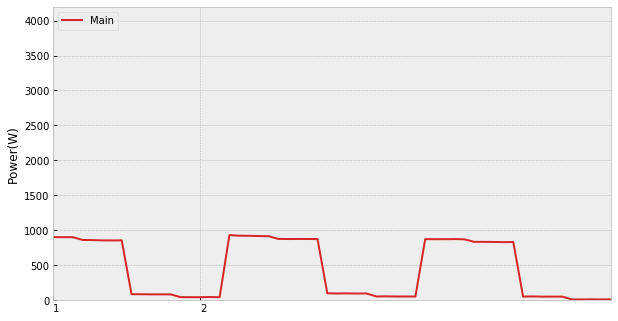

In [5]:
rcParams['figure.figsize'] = (10, 6)

t0='2022-02-02 12:00:00+01:00'
t1='2022-02-02 12:15:00+01:00'
t2='2022-02-02 12:58:00+01:00'

ax1 = next(valid_Main.load(ac_type='active', sample_period=60, resample_kwargs={'how':'first'}))[t0:t2].plot(c='tab:red') 
ax1.legend(['Main'], loc='upper left') #etiquetas
ax1.minorticks_off()
ax1.set(xticks=(t0, t1))
ax1.set_xticklabels(labels=['1','2'], ha='left', rotation=0)    
ax1.set_ylabel('Power(W)')
ax1.set_ylim(0,4200)
plt.savefig('./data/images/5.1_Plot_valid_main.svg', bbox_inches='tight', transparent=True)
pass

Tambien podemos ver el agregado de los diferentes contadores.

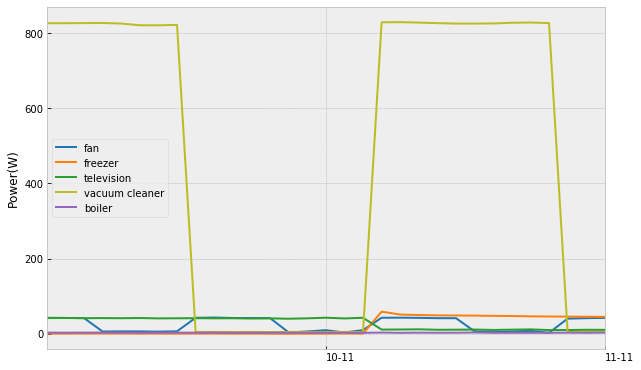

In [6]:
rcParams['figure.figsize'] = (10, 7)

t0='2022-02-02 12:00:00+01:00'
t1='2022-02-02 12:15:00+01:00'
t2='2022-02-02 12:30:00+01:00'

ax2 = valid_Devices.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})[t0:t2].plot()  
#colores
colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple']
c=0
for col in colors:    
    ax2.get_lines()[c].set_color(col)
    c=c+1   
ax2.legend(list(Meters.values())[1:6])
ax2.minorticks_off()
ax2.set(xticks=(t1, t2))
ax2.set_xticklabels(labels=['10-11','11-11'], ha='left', rotation=0)    
ax2.set_ylabel('Power(W)')
plt.savefig('./data/images/5.2_Plot_valid_devices.svg', bbox_inches='tight', transparent=True)
pass

### Desagregación para validación

La desagregación de los datos de validación se realiza utilizando los datos del MeterGroup valid_Main, el cual contiene el ElecMeter de los datos agregados del sistema eléctrico. Así, el medidor principal  será el dato de entrada para cada uno de los modelos de desagregación entrenados.


Veamos la degregacion  usando difrentes periodos de sampleo , difrentes metodos  y dos de los algoritmos mas tipicos como es el algoritmo combinatorio (CO) y el de las cadenas de Markovv (FHMM)

In [7]:
train = DataSet('dsual.h5')

train.set_window(start="2022-02-02 12:00:00", end="2022-02-02 12:58:00")
train_elec = train.buildings[1].elec

#Dispositivos para entrenamiento
train_Devices = train_elec.select(instance=[2,3,4,5,6])
train_Devices

from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM

periods = {'10s':10 , '30s':30, '60s':60, '5min':60*5, '10min':60*10, '15min':60*15, '30min':60*30}
methods = ['mean', 'median','first']

dir_models = './data/NILM/Models/'
times = {} #almacena tiempos de ejecución
null= {} #diccionario nulo
    
for sp_name, sp in periods.items():
    t = []
    
    for method in methods:
        models={'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}

        for model_name, model in models.items():
            print("*"*20 + ' ' + model_name + ' ' + sp_name+ ' ' + method + "*"*20)
            #Entrenamiento
            model.MIN_CHUNK_LENGTH = 1
            import time
            start = time.time()
            model.train(train_Devices,
                        num_states_dict={ }, #diccionario de estados nulo, por defecto
                        ac_type='active', #potencia activa, por defecto
                        sample_period=sp, #cambio de muestreo
                        resample_kwargs={'how':method}) #método

            t.append(round(time.time()-start,2)) #tiempo de simulación

            #Guarda modelo
            #model_dir = dir_models + model_name + '_' + sp_name + '_' + method + '_model.pickle'
            #model.export_model(model_dir) 
            output=HDFDataStore(data_dir+'NILM/Results/'+model_name+'_'+sp_name+'_'+method+'_pred.h5', 'w')
            
            model.disaggregate(valid_Main, output, sample_period=sp, resample_kwargs={'how':method}, ac_type='active')
            output.close()
            # end = time.time()-start
            # t.append(round(end,2))

    times[sp_name] = t #tiempo de simulación

#ValueError: Shape of passed values is (4, 8), indices imply (6, 8)    
times_v = pd.DataFrame(times,index=['CO_mean', 'FHMM_mean', 'CO_median', 'FHMM_median','CO_first', 'FHMM_first'])
    
    
print('\n\nDone!')

******************** CO 10s mean********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])'
Done training!
Estimating power demand for 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Estimating power demand for 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])'


Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])' with 1 states
******************** CO 30s median********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', applia

******************** FHMM 60s median********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])' with 1 states
******************** CO 60s first********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Training model for s

******************** FHMM 5min first********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])' with 1 states
******************** CO 10min mean********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Training model for 

******************** FHMM 15min mean********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])' with 1 states
******************** CO 15min median********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Training model fo

Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])' with 1 states
******************** CO 30min first********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSU

In [12]:
times_v.transpose()

,CO_mean,FHMM_mean,CO_median,FHMM_median,CO_first,FHMM_first
10s,4.10,5.63,4.07,5.51,4.27,5.42
30s,3.96,4.76,4.31,5.05,4.33,4.92
60s,4.18,4.67,3.90,4.92,4.07,4.94
5min,4.87,8.69,5.71,8.83,5.03,8.76
10min,5.74,8.80,5.75,8.81,5.02,8.59
15min,5.70,8.70,5.06,8.69,5.71,8.83
30min,5.17,8.70,5.74,8.80,5.42,8.94


### Métricas individuales del modelo

In [25]:
#Librerías
from nilmtk.metrics import f1_score
from nilmtk.metrics import error_in_assigned_energy
from nilmtk.metrics import mean_normalized_error_power
from nilmtk.metrics import rms_error_power
from nilmtk.metrics import fraction_energy_assigned_correctly

In [26]:
index = list(labels['Meters'][1:6])
met = []
e = []
#Datos de Dispositivos: predicción
dataset=DataSet(data_dir+'NILM/Results/CO_60s_first_pred.h5')
predictions=dataset.buildings[1].elec.submeters()      
#Metricas
f1 = {}; eae = {}; feac = {}; mneap = {}; rmse = {};

f1['F1'] = f1_score(predictions, valid_Devices)

EAE = error_in_assigned_energy(predictions, valid_Devices)
for x in range(len(EAE)): e.append(EAE.iloc[x][0])
eae['EAE'] = e

#da error esta medida AttributeError: 'tuple' object has no attribute 'instance'
#feac['FEAC'] = np.ones(6)*(fraction_energy_assigned_correctly(predictions, valid_Devices))


mneap['MNEAP'] = mean_normalized_error_power(predictions, valid_Devices)

rmse['RMSE'] = rms_error_power(predictions, valid_Devices)

met.append(pd.concat([pd.DataFrame(feac, index=valid_Devices.instance()),
                      pd.DataFrame(f1),
                      pd.DataFrame(eae, index=valid_Devices.instance()),
                      pd.DataFrame(mneap),
                      pd.DataFrame(rmse)],
                     axis=1).set_index(pd.Index(index)))

dataset.store.close()       
print('\n\nDone!')
metrics=met[0].transpose().round(3)
metrics



Done!


,fan,freezer,television,vacuum cleaner,boiler
F1,0.760,0.698,0.588,0.943,0.000
EAE,0.000,0.000,0.000,0.000,0.000
MNEAP,0.512,0.633,0.411,0.123,1.000
RMSE,17.556,20.821,15.814,153.797,2.711


### Análisis particular del cálculo de cada métrica

Metrica FEAC

In [38]:
#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})
gt.columns=list(Meters.values())

In [39]:
predictions_Devices=elec_CO_60s_first.submeters()
frac_1 = valid_Devices.fraction_per_meter()
frac_2 = predictions_Devices.fraction_per_meter()
fig, (ax1, ax2) = plt.subplots(1, 2 ,gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
frac_1.plot(autopct=lambda p:'{:.0f}%'.format(p), kind='pie',
            labels=list(Meters.values())[1:6], figsize=(8,8), ax=ax1,
            colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan'])
frac_2.plot(autopct=lambda p:'{:.0f}%'.format(p), kind='pie',
            labels=list(Meters.values())[1:6], figsize=(8,8), ax=ax2,
            colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan']) 
ax1.set(ylabel="")
ax1.set(xlabel="GT")
ax2.set(ylabel="")
ax2.set(xlabel="Predictions")
plt.savefig('./data/images/5.4_FEAC_CO_60s.svg', bbox_inches='tight', transparent=True)
pass

NameError: name 'elec_CO_60s_first' is not defined

Métrica F1

In [40]:
pd.DataFrame(metrics.loc['F1']).transpose()*100

,fan,freezer,television,vacuum cleaner,boiler
F1,76.0,69.8,58.8,94.3,0.0


NameError: name 'pred_CO' is not defined

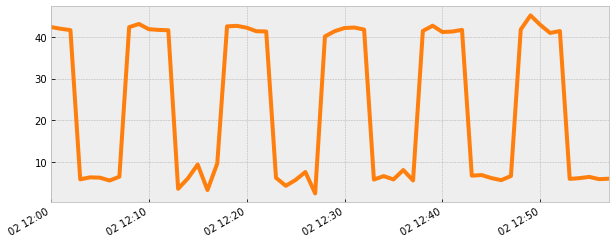

In [41]:
rcParams['figure.figsize'] = (10, 4)
t0='2022-02-02 10:00:00+01:00' #tiempo inicial
t1='2022-02-02 14:00:00+01:00' #tiempo final
fig, ax1 = plt.subplots();
ax1=gt['fan'].plot(lw=4, c='tab:orange')
pred_CO['fan'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['fan','Pred_CO'], fontsize=9, loc='upper left', ncol=1)
ax1.set_ylim(-10,650)
ax1.set_xlim(t0,t1)
ax1.minorticks_off()
ax1.set_xticklabels(labels=['10:00','10:30','11:00','11:30','12:00','12:30','13:30','14:00']
                    , horizontalalignment ='right')  
ax1.set_ylabel('Power (W)')
ax1.annotate('TP', xy=(250, 188), xycoords='figure points', xytext=(285, 210), fontweight='bold',
             arrowprops=dict(facecolor='red', width=3, headwidth=10))
ax1.annotate('TN', xy=(365, 38), xycoords='figure points', xytext=(400, 70), fontweight='bold',
             arrowprops=dict(facecolor='red', width=3, headwidth=10))
ax1.annotate('FN', xy=(492, 38), xycoords='figure points', xytext=(530, 70), fontweight='bold',
             arrowprops=dict(facecolor='red', width=3, headwidth=10))
ax1.annotate('FP', xy=(187, 188), xycoords='figure points', xytext=(220, 210), fontweight='bold',
             arrowprops=dict(facecolor='red', width=3, headwidth=10))
plt.savefig('./data/images/5.5_F1_CO_60s.svg', bbox_inches='tight', transparent=True)
pass

metrica EAE

In [42]:
round(pd.DataFrame(metrics.loc['EAE']).transpose(),2)

,fan,freezer,television,vacuum cleaner,boiler
EAE,0.0,0.0,0.0,0.0,0.0


In [43]:
e1=predictions_Devices[5].total_energy()[0]
e2=valid_Devices[5].total_energy()[0]
eae=round(abs(e1-e2),2)

pd.DataFrame([e1,e2,eae], columns=['kWh'], index=['Energy_pred','Energy_GT','EAE'])

NameError: name 'predictions_Devices' is not defined

metrica MNEAP

In [44]:
round(pd.DataFrame(metrics.loc['MNEAP']).transpose(),2)

,fan,freezer,television,vacuum cleaner,boiler
MNEAP,0.51,0.63,0.41,0.12,1.0


TypeError: no numeric data to plot

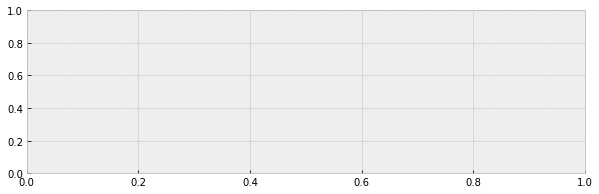

In [45]:
rcParams['figure.figsize'] = (10, 3)
fig, ax1 = plt.subplots();
a1=[1240,1250]
gt['freezer'][a1[0]:a1[1]].plot(ax=ax1, lw=2, c='tab:purple', marker="D")
pred_CO['freezer'][a1[0]:a1[1]].plot(ax=ax1, c='darkred', lw=1, ls='--', marker="D")
ax1.minorticks_off()
ax1.set_ylabel('Power (W)')
ax1.legend(labels=['GT freezer','Pred_CO'], fontsize=9, ncol=1)

err= abs(round((gt['freezer'][a1[0]:a1[1]]-pred_CO['freezer'][a1[0]:a1[1]])[1:9],1))
aux=40
i=0
for e in err:
    ax1.annotate((str(err[i])+'W'), xy=(aux, 30+(abs(err[i]))*0.2), xycoords='axes points', size=10)
    aux=aux+63
    i=i+1

ax1.set_xticklabels(labels=['10:00','10:30','11:00','11:30','12:00','12:30','13:00','13:30','14:00',''])   
plt.savefig('./data/images/5.6_MNEAP_CO_60s.svg', bbox_inches='tight', transparent=True)
pass

Metrica RMSE

In [46]:
round(pd.DataFrame(metrics.loc['RMSE']).transpose(),1)

,fan,freezer,television,vacuum cleaner,boiler
RMSE,17.6,20.8,15.8,153.8,2.7


In [47]:
from nilmtk.metrics import fraction_energy_assigned_correctly, f1_score, error_in_assigned_energy
from nilmtk.metrics import mean_normalized_error_power, rms_error_power 
periods = {'10s':10 , '30s':30, '60s':60, '5min':60*5, '10min':60*10, '15min':60*15, '30min':60*30}

dir_predictions = data_dir +'NILM/Results/'
m = {}
classifiers = ['CO', 'FHMM']
methods = ['first', 'mean', 'median']
index = list(labels['Meters'][4:10])

for p_name, sp in periods.items():
    met = []
    for method in methods:
        for clf_name in classifiers:
            print('\nCalculando Metricas: '+ clf_name + '_' + p_name + '_' + method)  
            #Datos de Dispositivos: predicción
            input_dir = dir_predictions + clf_name + '_' + p_name + '_' + method +'_pred.h5'
            dataset = DataSet(input_dir)
            predictions=dataset.buildings[1].elec.submeters()       
            #Metricas
            f1 = {}; eae = {}; feac = {}; mneap = {}; rmse = {}; e=[];  
            F1 = f1_score(predictions, valid_Devices)
            f1['F1'] = F1*100
            EAE = error_in_assigned_energy(predictions, valid_Devices)
            for x in range(len(EAE)): e.append(EAE.iloc[x][0])
            eae['EAE'] = e
            feac['FEAC'] = 100*np.ones(6)*(fraction_energy_assigned_correctly(predictions, valid_Devices))
            mneap['MNEAP'] = mean_normalized_error_power(predictions, valid_Devices)
            rmse['RMSE'] = rms_error_power(predictions, valid_Devices)
            met.append(pd.concat([pd.DataFrame(feac, index=valid_Devices.instance()),
                                  pd.DataFrame(f1),
                                  pd.DataFrame(eae, index=valid_Devices.instance()),
                                  pd.DataFrame(mneap),
                                  pd.DataFrame(rmse)],
                                 axis=1).set_index(pd.Index(index)))
            dataset.store.close()        
    m[p_name] = met
##Guarda resultados
f = open(data_dir +'NILM/metrics.txt',"w")
f.write( str(m) )
f.close()
print('\n\nDone!')
#m[0] #CO first #m[1] #FHMM first #m[2] #CO mean #m[3] #FHMM mean #m[4] #CO median #m[5] #FHMM median


Calculando Metricas: CO_10s_first
5/5 ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])nce=1)])

AttributeError: 'tuple' object has no attribute 'instance'

## Otras Metricas: métricas Promedio

In [48]:
m_mean = {}

cols=['FEAC','F1','EAE','MNEAP','RMSE']
labels=['CO-first', 'CO-mean', 'CO-median', 'FHMM-first', 'FHMM-mean' ,'FHMM-median']
per=['10s','30s','60s','5min','10min','15min','30min']

for c in cols:
    m_mean[c] = pd.DataFrame([#CO FIRST
                             [m['10s'][0][c].mean(),m['30s'][0][c].mean(),m['60s'][0][c].mean(),
                              m['5min'][0][c].mean(),m['10min'][0][c].mean(),
                              m['15min'][0][c].mean(),m['30min'][0][c].mean()],
                              #CO MEAN
                             [m['10s'][2][c].mean(),m['30s'][2][c].mean(),m['60s'][2][c].mean(),
                              m['5min'][2][c].mean(),m['10min'][2][c].mean(),
                              m['15min'][2][c].mean(),m['30min'][2][c].mean()],
                              #CO MEDIAN
                             [m['10s'][4][c].mean(),m['30s'][4][c].mean(),m['60s'][4][c].mean(),
                              m['5min'][4][c].mean(),m['10min'][4][c].mean(),
                              m['15min'][4][c].mean(),m['30min'][4][c].mean()],
                             #FHMM FIRST
                             [m['10s'][1][c].mean(),m['30s'][1][c].mean(),m['60s'][1][c].mean(),
                             m['5min'][1][c].mean(),m['10min'][1][c].mean(),
                              m['15min'][1][c].mean(),m['30min'][1][c].mean()],
                             #FHMM MEAN            
                             [m['10s'][3][c].mean(),m['30s'][3][c].mean(),m['60s'][3][c].mean(),
                              m['5min'][3][c].mean(),m['10min'][3][c].mean(),
                              m['15min'][3][c].mean(),m['30min'][3][c].mean()],
                             #FHMM MEDIAN
                             [m['10s'][5][c].mean(),m['30s'][5][c].mean(),m['60s'][5][c].mean(),
                              m['5min'][5][c].mean(),m['10min'][5][c].mean(),
                              m['15min'][5][c].mean(),m['30min'][5][c].mean()]],columns=per, index=labels).transpose()
m_mean

KeyError: '10s'

Maximos


In [49]:
cols=['FEAC','F1','EAE','MNEAP','RMSE']

maxs=pd.concat([m_mean['FEAC'].transpose().max(),
                m_mean['F1'].transpose().max(),
                m_mean['EAE'].transpose().min(),
                m_mean['MNEAP'].transpose().min(),
                m_mean['RMSE'].transpose().min()], axis=1)
maxs.columns=cols
maxs = maxs.transpose()
round(maxs,2)

KeyError: 'FEAC'

Correspondencia de Indice

In [50]:
cols=['FEAC','F1','EAE','MNEAP','RMSE']

maxs_i=pd.concat([m_mean['FEAC'].transpose().idxmax(),
                 m_mean['F1'].transpose().idxmax(),
                 m_mean['EAE'].transpose().idxmin(),
                 m_mean['MNEAP'].transpose().idxmin(),
                 m_mean['RMSE'].transpose().idxmin()], axis=1)
maxs_i.columns=cols
maxs_i = maxs_i.transpose()
maxs_i

KeyError: 'FEAC'

KeyError: 'FEAC'

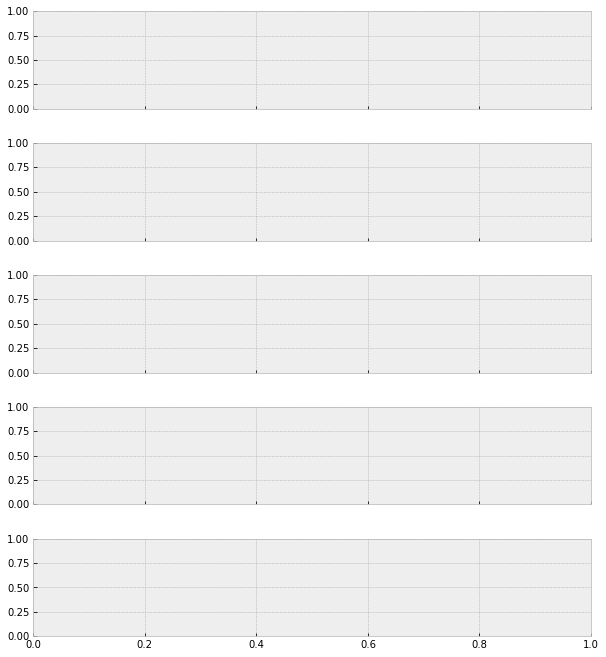

In [51]:
rcParams['figure.figsize'] = (10, 11.5)
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, sharex=True, gridspec_kw={'hspace': 0.35})
cols=['FEAC','F1','EAE','MNEAP','RMSE']
ylabels=['[%]','[%]','[kWh]','[-]','[W]']
per=['10s','30s','60s','5min','10min','15min','30min']

labels={'CO-first':-0.35, 'CO-mean':-0.22, 'CO-median':-0.11, 'FHMM-first':0.01, 'FHMM-mean':0.13 ,'FHMM-median':0.245}

c=0
for ax in fig.get_axes():      
    m_mean[cols[c]].plot.bar(ax=ax, width=0.7, edgecolor='black', linewidth=0.5, legend=False, cmap="jet")
    ax.set(ylabel=ylabels[c])
    ax.grid(b=None)
    x = 0
    for p in per:
        ax.annotate("▼", xy=(labels[maxs_i[p][cols[c]]]+x, maxs[p][cols[c]]+maxs[p][cols[c]]*0.03))
        x+=1
    c+=1
    
ax5.set_xticklabels(labels=per, rotation=0, fontdict={'fontsize':12})
fig.align_ylabels([(ax1,ax2,ax3,ax4,ax5)])
ax1.set(ylim=(0,120))
ax1.set_yticks([0,25,50,75,100])
ax2.set(ylim=(0,120))
ax2.set_yticks([0,25,50,75,100])
ax5.set_yticks([0,50,100,150,200])
ax1.set_title('Fraction of Energy Assigned Correctly - FEAC', fontsize=11, loc='center')
ax2.set_title('F1-Score', fontsize=11, loc='center')
ax3.set_title('Error in Assigned Energy - EAE', fontsize=11, loc='center')
ax4.set_title('Mean Normalised Error in Assigned Power - MNEAP', fontsize=11, loc='center')
ax5.set_title('RMS Error in Assigned Power - RMSE', fontsize=11, loc='center')
lgd = ax5.legend(labels.keys(), loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.6),fontsize=9.5)


ax1.annotate("97.1%", xy=(5.8, 100)); #30min FHMM-median
ax2.annotate("90.5%", xy=(0.68, 98)); #30s FHMM-mean
ax3.annotate("0.19", xy=(6.22, 1.4)); #30min FHMM-median
ax3.annotate("kWh", xy=(6.22, 0.9)); #30min FHMM-median
ax4.annotate("0.24", xy=(6.22, 0.7)); #30min FHMM-median
ax5.annotate("41.5", xy=(6.22, 120)); #30min FHMM-median
ax5.annotate("   W", xy=(6.22, 90)); #30min FHMM-median


plt.savefig('./data/images/5.7_All_metrics.svg', bbox_inches='tight', transparent=True)

pass

KeyError: '30min'

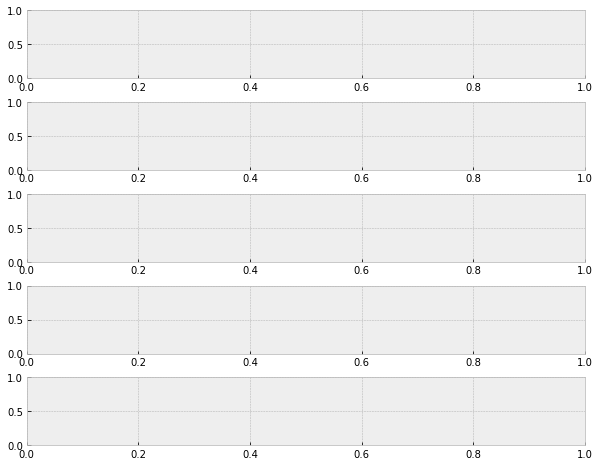

In [52]:
rcParams['figure.figsize'] = (10, 8)

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, sharex=False, gridspec_kw={'hspace': 0.35})
cols=['FEAC','F1','EAE','MNEAP','RMSE']
ylabels=['[%]','[%]','[kWh]','[-]','[W]']
labels=['FHMM-first', 'FHMM-mean' ,'FHMM-median']
c=0

for ax in fig.get_axes():
    
    df=pd.DataFrame([m['30min'][1][cols[c]],m['30min'][3][cols[c]],m['30min'][5][cols[c]]]).transpose()
    if ax==ax1:
        df['FEAC'].mean().plot.barh(ax=ax1, width=0.7, edgecolor='black', linewidth=0.5, legend=False,
                                    color=['greenyellow','darkorange','maroon'])
    else:
        df.plot.bar(ax=ax, width=0.7, edgecolor='black', linewidth=0.5, legend=False,
                    color=['greenyellow','darkorange','maroon'])
    ax.set(ylabel=ylabels[c])
    ax.grid(b=None)
    c+=1   
    
ax1.set_xticklabels(['0','','','','','100'])
ax1.set_yticklabels('')
ax2.set_xticklabels('')
ax3.set_xticklabels('')
ax4.set_xticklabels('')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=0, fontdict={'fontsize':12})
fig.align_ylabels([(ax1,ax2,ax3,ax4,ax5)])
ax1.set(xlim=(0,108))
ax2.set(ylim=(0,120))
ax3.set_yticks([0,1,2,3,4])
ax4.set(ylim=(0,1.8))
ax4.set_yticks([0,0.5,1,1.5,2])
ax5.set(ylim=(0,270))
ax5.set_yticks([0,100,200,300])
ax1.set_title('Fraction of Energy Assigned Correctly - FEAC', fontsize=11, loc='center')
ax2.set_title('F1-Score', fontsize=11, loc='center')
ax3.set_title('Error in Assigned Energy - EAE', fontsize=11, loc='center')
ax4.set_title('Mean Normalised Error in Assigned Power - MNEAP', fontsize=11, loc='center')
ax5.set_title('RMS Error in Assigned Power - RMSE', fontsize=11, loc='center')
lgd = ax5.legend(labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))

ax1.annotate("◄ 97.1%", xy=(98, 1.9))

plt.savefig('./data/images/5.8_All_metrics_2.svg', bbox_inches='tight', transparent=True)

pass

In [ ]:
print('FHMM-first')
print(m['30min'][1])
print('\nFHMM-mean')
print(m['30min'][3])
print('\nFHMM-median')
print(m['30min'][5])

### Resultados del mejor modelo
En vista de los resultados del obtenidos, se propone la elección del modelo FHMM entrenado con datos promedio de dispositivos cada 10 minutos. Este modelo solo se considera adecuado para la desagregación de datos promedio de potencia activa medidos en cabecera cada 10 minutos.

KeyError: '30min'

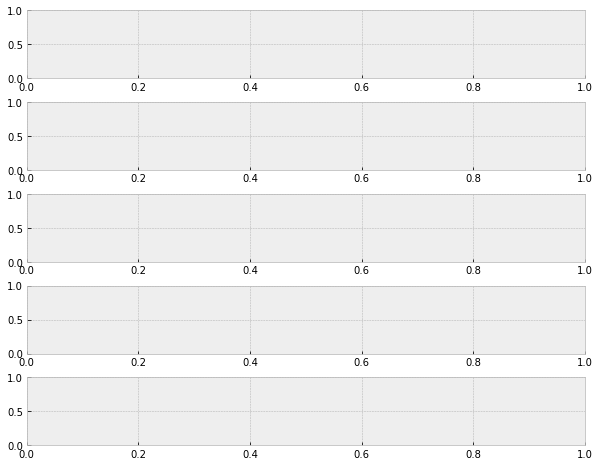

In [53]:
rcParams['figure.figsize'] = (10, 8)

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, sharex=False, gridspec_kw={'hspace': 0.35})
cols=['FEAC','F1','EAE','MNEAP','RMSE']
ylabels=['[%]','[%]','[kWh]','[-]','[W]']
colors=['tab:red','tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan']
c=0

for ax in fig.get_axes():
    df=pd.DataFrame(m['30min'][5][cols[c]])
    if ax==ax1:
        pass
        df.mean().plot.barh(ax=ax1, width=0.7, edgecolor='black', linewidth=0.5, legend=False, color='gold')
    else:
        df[cols[c]].plot.bar(ax=ax, width=0.7, edgecolor='black', linewidth=0.5, legend=False, color=colors)
    ax.set(ylabel=ylabels[c])
    ax.grid(b=None)
    c+=1

ax1.set_xticklabels(['0','','','','','100'])
ax1.set_yticklabels('')
ax2.set_xticklabels('')
ax3.set_xticklabels('')
ax4.set_xticklabels('')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=0, fontdict={'fontsize':12})
fig.align_ylabels([(ax1,ax2,ax3,ax4,ax5)])
ax1.set(xlim=(0,105))
ax2.set(ylim=(0,125))
ax3.set(ylim=(0,1))
ax4.set(ylim=(0,0.7))
ax5.set(ylim=(0,110))

#ax2.set_yticks([0,25,50,75,100])
#ax3.set_yticks([0,1,2,3])
#ax4.set_yticks([0,1,2,3,4])
#ax5.set_yticks([0,50,100,150,200])

ax1.set_title('Fraction of Energy Assigned Correctly - FEAC', fontsize=11, loc='center')
ax2.set_title('F1-Score', fontsize=11, loc='center')
ax3.set_title('Error in Assigned Energy - EAE', fontsize=11, loc='center')
ax4.set_title('Mean Normalised Error in Assigned Power - MNEAP', fontsize=11, loc='center')
ax5.set_title('RMS Error in Assigned Power - RMSE', fontsize=11, loc='center')

df=pd.DataFrame(m['30min'][5])
ax1.annotate(str(round(df['FEAC'][3],1))+'%', xy=(df['FEAC'][0]+1 , 0.01), fontsize=9.5)
for x in range(6):ax2.annotate(str(round(df['F1'][x],1))+'%', xy=(x-0.18 , df['F1'][x]+4),fontsize=9.5)
for x in range(6):ax3.annotate(str(round(df['EAE'][x],1))+' kWh', xy=(x-0.25 , df['EAE'][x]+0.1),fontsize=9.5)
for x in range(6):ax4.annotate(str(round(df['MNEAP'][x],1)), xy=(x-0.08 , df['MNEAP'][x]+0.03),fontsize=9.5)
for x in range(6):ax5.annotate(str(round(df['RMSE'][x]))+' W', xy=(x-0.18 , df['RMSE'][x]+5),fontsize=9.5)

plt.savefig('./data/images/5.9_Metrics_FHMM_30min_median.svg', bbox_inches='tight', transparent=True)

In [54]:
valid_Devices.total_energy()

Calculating total_energy for ElecMeterID(instance=6, building=1, dataset='DSUAL') ...   

apparent    15.427855
active       0.440416
reactive     0.024328
dtype: float64

In [55]:
valid_Devices.energy_per_meter()

5/5 ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])nce=1)])

,"(2, 1, DSUAL)","(3, 1, DSUAL)","(4, 1, DSUAL)","(5, 1, DSUAL)","(6, 1, DSUAL)"
active,0.022232,0.016073,0.019346,0.380146,0.002619
apparent,NaN,NaN,NaN,NaN,NaN
reactive,NaN,NaN,NaN,NaN,NaN


### Replicando el entrenamiento del modelo

In [56]:
from nilmtk import DataSet
from nilmtk.legacy.disaggregate import FHMM


train = DataSet('dsual.h5')

train.set_window(start="2022-02-02 00:00:00", end="2022-02-03 23:59:59")
train_elec=train.buildings[1].elec 

#dispositivos a entrenar: [Lights_1, Lights_2, HVAC_1, HVAC_2, HVAC_4, Rack]
train_Devices=train_elec.select(instance=[2,3,4,5,6])

#opcional: asignación manual de estados de dispositivos
num_states={train_Devices[2]:2, train_Devices[3]:3, train_Devices[4]:4,
            train_Devices[5]:5, train_Devices[6]:6}

#entrenamiento y exportación del modelo
FHMM_30min_median=FHMM()
FHMM_30min_median.MIN_CHUNK_LENGTH=1
FHMM_30min_median.train(train_Devices,
                        num_states_dict={}, #en otro caso: { }
                        ac_type='active',
                        sample_period=1800,
                        resample_kwargs={'how':'median'})

FHMM_30min_median.export_model('./data/FHMM_30min_median_model.pickle') 

Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])' with 1 states


AttributeError: Can't pickle local object 'WeakValueDictionary.__init__.<locals>.remove'

In [ ]:
Examinamos el modelo

In [ ]:
from nilmtk.legacy.disaggregate import FHMM
FHMM=FHMM()
FHMM.import_model('C:/data/FHMM_30min_median_model.pickle') 
print(type(FHMM.individual[valid_Devices[5]].means_))
print('Lights_1: '+str(FHMM.individual[valid_Devices[5]].means_))
print('Lights_1: '+str(FHMM.individual[valid_Devices[6]].means_))
print('HVAC_1: '+str(FHMM.individual[valid_Devices[7]].means_))
print('HVAC_2: '+str(FHMM.individual[valid_Devices[8]].means_))
print('HVAC_4: '+str(FHMM.individual[valid_Devices[9]].means_))
print('Rack: '+str(FHMM.individual[valid_Devices[10]].means_))

### Comparacion de resultados

Utilizaremos dos archivos de resultados (CO y FHMM 60s - first) para visualizar las predicciones hechas por los modelos y contrastarlas con las mediciones reales de dispositivos en cada caso.

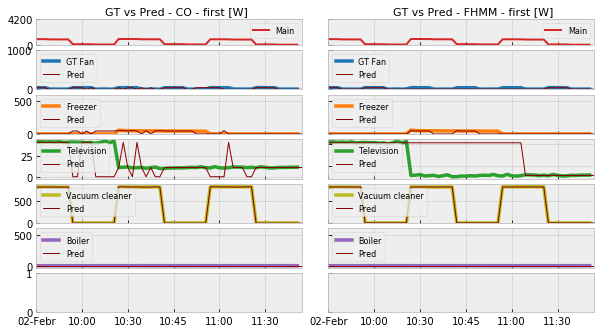

In [57]:
#resultados de predicción modelo CO 60s
CO_60s_first=DataSet(data_dir+'NILM/Results/CO_60s_first_pred.h5')
elec_CO_60s_first=CO_60s_first.buildings[1].elec
#resultados de predicción modelo FHMM 60s
FHMM_60s_first=DataSet(data_dir+'NILM/Results/FHMM_60s_first_pred.h5')
elec_FHMM_60s_first= FHMM_60s_first.buildings[1].elec


#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_60s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]


pred_FHMM=elec_FHMM_60s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]



#graficos
rcParams['figure.figsize'] = (10, 6)

fig, ((ax_a,ax_b),(ax1,ax7),(ax2,ax8),(ax3,ax9),
      (ax4,ax10),(ax5,ax11),(ax6,ax12)) = plt.subplots(7, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3]})

t='60s'; m1='_CO'; m2='_FHMM'; f=8
pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6],[ax_b,ax7,ax8,ax9,ax10,ax11,ax12]]

for i in range(2):

    gt['main'].plot(ax=ax[i][0], color='tab:red',legend=False)
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['fan'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['fan'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['freezer'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['freezer'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['vacuum cleaner'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['vacuum cleaner'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['boiler'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['boiler'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['Boiler','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)
    
    
   
    
    ax[i][6].minorticks_off()
  #  ax[i][6].set(xticks=['2022-02-02 00:00:00+01:00','2022-02-02 06:00:00+01:00','2022-02-02 12:00:00+01:00','2022-02-02 12:00:00+01:00','2022-02-02 18:00:00+01:00','2022-02-02 23:50:00+01:00'])
    ax[i][6].set_xticklabels(labels=['02-Febr','10:00','10:30','10:45','11:00','11:30','12:00','12:30','13:00'])       

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - first [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - first [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_60s.svg', bbox_inches='tight', transparent=True)
pass